# Analyzing a Fortran Stencil Program

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Understanding

Open the <tt>stencil2d-orig.F90</tt> Fortran program by double clicking on the file in the File Browser on the left (if it is hidden, click on the Folder icon).

![open-stencil2d](img/open-stencil2d.png)

If you prefer, you can also open a new Terminal (File -> New -> Terminal), navigate to the location where <tt>stencil2d-orig.F90</tt> is located and use your favorite linux editor (e.g. vim) to browse the Fortran source code. This will give you better syntax highlighting.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Read the code of <tt>stencil2d-orig.F90</tt> and understand what the program is doing.<br>
<b>2.</b> Compile the code and run it (see below).<br>
<b>3.</b> In the source code <tt>stencil2d-counters.F90</tt> there are two global variables of type <tt>integer</tt> named <tt>flop_counter</tt> and <tt>byte_counter</tt>. Edit the program to count the number of floating-point operations and bytes transferred to/from memory. Compile and run.<br>
</div>

## Compiling

On Piz Daint, the programming environment is managed using so called modules. We need to load the right modules in order to compile our program. We are going to use the Cray Fortran compiler (<tt>PrgEnv-cray</tt>) for this exercise. (Note: If we are using <tt>%%bash</tt> cell magic, these commands need to be repeated every time to setup the right environment.

In [2]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=orig

rm -f -rf *~ *.o *.mod *.MOD *.i *.x *.x+orig *.x+[0-9]* core.* *.out
ftn -eZ -ffree -N255 -ec -eC -eI -eF -c m_utils.F90
ftn -eZ -ffree -N255 -ec -eC -eI -eF -c stencil2d-orig.F90
ftn -eZ -ffree -N255 -ec -eC -eI -eF m_utils.o stencil2d-orig.o -o stencil2d-orig.x
cp stencil2d-orig.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-orig.x' (lite-samples) ...OK


## Running

We can run our program on all 12 cores of the Xeon E5-2690 v3 Haswell CPU that we have available using the <tt>srun</tt> command. The command line arguments <tt>nx, ny, nz, num_iter</tt> specify the size of the computational domain as well as the number of iterations.

In [3]:
%%bash --out stdout
srun -n 12 ./stencil2d-orig.x+orig --nx 128 --ny 128 --nz 64 --num_iter 128

srun: Job 22970023 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 22970023


In [4]:
print(stdout)
exec(stdout)

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.1473855E+01], \
] )



In [5]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=counters

ftn -eZ -ffree -N255 -ec -eC -eI -eF -c stencil2d-counters.F90
ftn -eZ -ffree -N255 -ec -eC -eI -eF m_utils.o stencil2d-counters.o -o stencil2d-counters.x
cp stencil2d-counters.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-counters.x' (lite-samples) ...OK


In [6]:
%%bash --out stdout
srun -n 12 ./stencil2d-counters.x+orig --nx 128 --ny 128 --nz 64 --num_iter 128

In [7]:
print(stdout)
exec(stdout)

# ranks nx ny ny nz num_iter time flop byte
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.1535960E+01,  0.3476847E+10,  0.3415646E+11], \
] )



<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> Compute the arithmetic intensity $I$ of our stencil program using the flop and byte counters you have introduced.<br>
<b>4.</b> Compute the performance in GFLOP/s of our stencil program. Is our program memory bound or compute bound? Which % of peak FLOP/s and memory bandwidth do we achieve?<br>
<b>5.</b> Run the stencil program for different <tt>nx</tt> and <tt>ny</tt> (using the <tt>--scan</tt> option, see below). Import the data into a Python notebook and make a loglog-plot of the runtime per gridpoint $r = \mathrm{runtime} \, / \, nx \, / \, ny \, / nz$ in $\mu s$ versus the working set size $n = nx \times ny \times nz \times 3$ in MB. What would you expect for a von Neumann architecture? What might be the reason that the behavior is different? (Note: Running with the <tt>--scan</tt> will take some time to complete. Be patient!)
</div>

In [8]:
gflop_counter = data[0, 6] / 1024. / 1024. / 1024.
gb_counter = data[0, 7] / 1024. / 1024. / 1024.
arithmetic_intensity = gflop_counter / gb_counter
print("Arithmetic intensity = {}".format(arithmetic_intensity))

Arithmetic intensity = 0.10179178404319417


In [9]:
runtime = data[0, 5]
peak_bandwidth_in_gbs = 63.5683536529541
peak_performance_in_gflops = 249.69600000000003
performance_in_gflops = gflop_counter / runtime
bandwidth_in_gbs = gb_counter / runtime
performance_percent_peak = performance_in_gflops / peak_performance_in_gflops * 100.
bandwidth_percent_peak = bandwidth_in_gbs / peak_bandwidth_in_gbs * 100.
print("GFLOP/s = {} ({:6.3f}% theoretical peak)    GB/s = {} ({:6.3f}% theoretical peak)".format( \
    performance_in_gflops, performance_percent_peak, bandwidth_in_gbs, bandwidth_percent_peak))

GFLOP/s = 2.1081708505326326 ( 0.844% theoretical peak)    GB/s = 20.710618939914195 (32.580% theoretical peak)


In [10]:
%%bash --out stdout
srun -n 12 ./stencil2d-orig.x+orig --scan --nz 64 --num_iter 128

In [15]:
print(stdout)
exec(stdout)
data_orig = data

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,   16,   16,   64,     128,  0.6330947E-02], \
[   12,   32,   16,   64,     128,  0.9917994E-02], \
[   12,   48,   16,   64,     128,  0.1302644E-01], \
[   12,   64,   16,   64,     128,  0.1636597E-01], \
[   12,   96,   16,   64,     128,  0.2251311E-01], \
[   12,  128,   16,   64,     128,  0.3314946E-01], \
[   12,  192,   16,   64,     128,  0.1796055E+00], \
[   12,   16,   32,   64,     128,  0.1240720E-01], \
[   12,   32,   32,   64,     128,  0.1791322E-01], \
[   12,   48,   32,   64,     128,  0.2383135E-01], \
[   12,   64,   32,   64,     128,  0.3547416E-01], \
[   12,   96,   32,   64,     128,  0.1658968E+00], \
[   12,  128,   32,   64,     128,  0.3094409E+00], \
[   12,  192,   32,   64,     128,  0.5271306E+00], \
[   12,   16,   48,   64,     128,  0.1952318E-01], \
[   12,   32,   48,   64,     128,  0.2622155E-01], \
[   12,   48,   48,   64,     128,  0.5589892E-01], \
[   12,   64,   48,   64,  

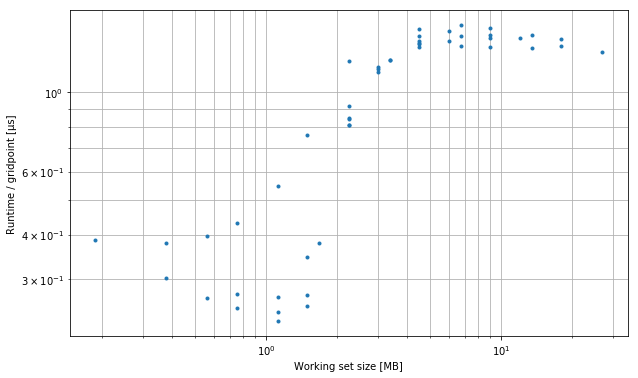

In [16]:
nxnynz = data[:, 1] * data[:, 2] * data[:, 3]
runtime = data[:, 5]
plt.loglog( 3 * nxnynz * 4 / 1024. / 1024., runtime / nxnynz * 1.0e6 , '.');
plt.xlabel( 'Working set size [MB]' );
plt.ylabel( 'Runtime / gridpoint [µs]' );
plt.grid(b=True, which='both')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

## Performance Analysis Tool (perftool-lite)

We can also use a performance analysis tool from Cray named <tt>perftools-lite</tt> to analyze the performance of our stencil program. In fact, our program has already been compiled for performance analysis with <tt>perftools-lite</tt> since we have loaded the corresponding module. <tt>stencil2d-counters.x+orig</tt> is the original executable without instrumentation for performance analysis and <tt>stencil2d-counters.x</tt> is an executable specifically prepared for performance analysis.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>6.</b> Run your program with <tt>perftools-lite</tt>. Read the report generated by <tt>perftools-lite</tt> carefully. What can you learn from the profiling?<br>
<b>7.</b> Compare the memory transfer numbers against your values. By which factor are you off? What could be the reason?<br>
<b>8.</b> Run again with $nx = 64$ and $ny = 32$. Did the factor by which you are off change? Is this consistent with the findings above? Do you have an idea why this might be the case?<br>
</div>

*Solution:* <br>
Running at nx=128 ny=128 nz=65 and num_iter=1024 we have 255.2 GB from the counters and perftools-lite reports 128.2 GB, that's only 50% of our estimate from the counters.<br>
Running at nx=64 ny=32 nz=64 and num_iter=1024 we have 15.42 GB from the counters and perftools-lite reports 0.08 GB, that's only 0.52% of our estimate from the counters.<br>
The reason for the large discrepancy is that memory accesses are cached. We have 2.5 MB of L3 cache per core. A float32 field occupies 4 MB for <tt>nx x ny x nz</tt> = 128 x 128 x 64 and 0.125 MB for <tt>nx x ny x nz</tt> = 64 x 32 x 64. We have 3 fields in the code (<tt>in_field, tmp_field, out_field</tt>). In the first case we do not fit into L3 cache. In the second case, we easily fit into L3 cache and only have to read the fields once, after that they can be read from / written to in cache.

In [19]:
%%bash
echo "====== 128 x 128 x 64 ======"
srun -n 12 ./stencil2d-counters.x --nx 128 --ny 128 --nz 64 --num_iter 1024
echo "====== 64 x 32 x 64 ======"
srun -n 12 ./stencil2d-counters.x --nx 64 --ny 32 --nz 64 --num_iter 1024

====== 128 x 128 x 64 ======
# ranks nx ny ny nz num_iter time flop byte
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.1231850E+02,  0.2781477E+11,  0.2739563E+12], \
] )

#################################################################
#                                                               #
#            CrayPat-lite Performance Statistics                #
#                                                               #
#################################################################

CrayPat/X:  Version 7.1.1 Revision 7c0ddd79b  08/19/19 16:58:46
Experiment:                  lite  lite-samples
Number of PEs (MPI ranks):     12
Numbers of PEs per Node:       12
Numbers of Threads per PE:      1
Number of Cores per Socket:    12
Execution start time:  Tue Jun  2 08:48:26 2020
System name and speed:  nid02891  2.601 GHz (nominal)
Intel Haswell    CPU  Family:  6  Model: 63  Stepping:  2
DRAM:  64 GiB DDR4-2400 on 2.6 GHz nodes



Avg Process Time:             12

CrayPat/X:  Version 7.1.1 Revision 7c0ddd79b  08/19/19 16:58:46
